# **Detección de anomalías en los patrones de comportamiento de los clientes no regulados en la filial Electro Dunas del Grupo Energía Bogotá**

Este Notebook, hace parte del trabajo de grado de la maestría en inteligencia analítica de datos de la Universidad de los Andes en él se realizan la exploración del modelo PCA.  

Realizado por: Miller Puentes, Grace González, Camilo, Robayo, Joan Chacón.

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from ipywidgets import widgets, interact
from tqdm import tqdm
import plotly.express as px

# Configuración de estilos para gráficos
style.use('ggplot') or plt.style.use('ggplot')

# Supresión de warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Para colocar el enlace al Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Lista todos los archivos csv en la carpeta de gerencia
folder_path = '/content/drive/My Drive/MIAD_Gerencia de proyectos/4_Guía/Data'
files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Crea un DataFrame vacío para almacenar todos los datos
all_data = pd.DataFrame()

# Itera sobre los archivos y los concatena en el DataFrame all_data
for file in files:
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path)

    # Extrae el número de cliente del nombre del archivo (suponiendo que es el número que viene después de 'CLIENTE' y antes del '.csv')
    cliente_id = int(file.replace('DATOSCLIENTE', '').replace('.csv', ''))

    # Agrega la columna cliente_id al DataFrame
    data['Cliente_ID'] = cliente_id

    all_data = pd.concat([all_data, data], ignore_index=True)



# Asegúrate de cambiar el nombre del archivo y la ruta si es necesario
file_path = '/content/drive/My Drive/MIAD_Gerencia de proyectos/4_Guía/Data/sector_economico_clientes.xlsx'
sector_economico_clientes = pd.read_excel(file_path)

# Muestra las primeras filas del dataframe


sector_economico_clientes['Cliente_ID'] = (
    sector_economico_clientes['Cliente:']
    .str.extract('(\d+)')  # Extrae el número del nombre del cliente
    .astype(int)           # Convierte el resultado en entero
)

data_merged = pd.merge(all_data, sector_economico_clientes, on='Cliente_ID', how='left')

# Muestra las primeras filas del dataframe combinado
data_merged.head()

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Cliente:,Sector Económico:
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Cliente 1,Elaboración de cacao y chocolate y de producto...


**Eliminación de mediciones negativas del consumo**

In [4]:
data_filtered_neg = data_merged[data_merged['Active_energy'] >= 0]
print(data_merged.shape)
print(data_filtered_neg.shape)
data_filtered_neg.head()

(351020, 8)
(350515, 8)


,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Cliente:,Sector Económico:
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Cliente 1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Cliente 1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Cliente 1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Cliente 1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Cliente 1,Elaboración de cacao y chocolate y de producto...


## Exploración e identificación del número de componentes

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.48182947 0.2864445  0.21102279 0.02070324]

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.48182947 0.76827397 0.97929676 1.        ]

------------------
Valores originales
------------------


,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC
246317,4.457443,0.980230,746.016908,709.999466
246318,4.698414,4.057734,595.329779,679.061180
246319,3.228533,3.556386,669.818274,646.135216



---------------------
Valores reconstruidos
---------------------


,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC
246317,4.457443,0.980230,746.016908,709.999466
246318,4.698414,4.057734,595.329779,679.061180
246319,3.228533,3.556386,669.818274,646.135216


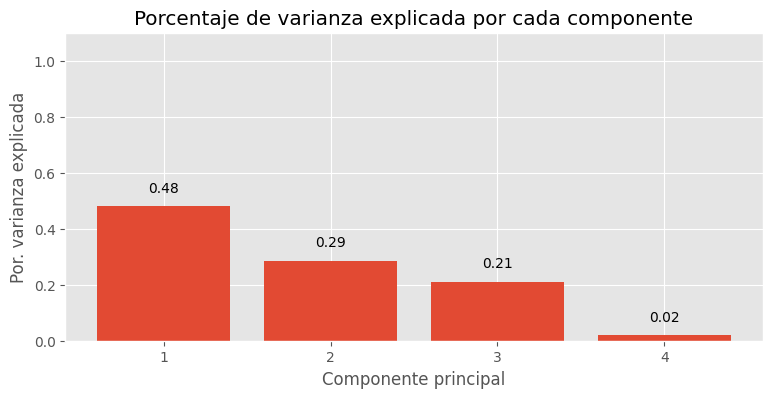

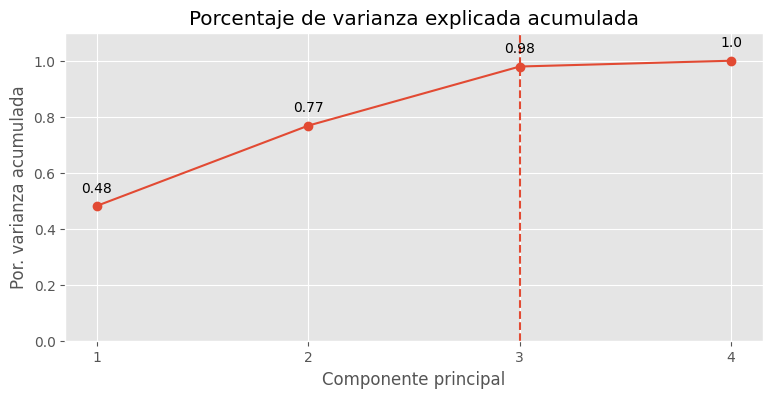

In [5]:
num_cliente =5

df = data_filtered_neg[data_filtered_neg['Cliente_ID'] == num_cliente]

# Seleccionar las columnas 'Fecha' y 'Active_energy'
df = df[[ 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]


# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=None))
pca_pipeline.fit(X=df)

# Se extrae el modelo entrenado del pipeline para su diagnóstico
modelo_pca = pca_pipeline.named_steps['pca']

# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(modelo_pca.n_components_) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')
print("");


# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.plot(
    np.arange(modelo_pca.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(modelo_pca.n_components_) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.axvline(x=3, linestyle = '--')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')
print("");

# Reconstrucción de las proyecciones
# ==============================================================================
proyecciones = pca_pipeline.transform(df)
reconstruccion = pca_pipeline.inverse_transform(proyecciones)
reconstruccion = pd.DataFrame(
                    reconstruccion,
                    columns = df.columns,
                    index   = df.index
)
print('------------------')
print('Valores originales')
print('------------------')
display(reconstruccion.head(3))

print('')
print('---------------------')
print('Valores reconstruidos')
print('---------------------')
display(df.head(3))

Con las primeras 3 componentes se consigue explicar aproximadamente el 96% de la varianza observada en los datos.

Se comprueba que, utilizando todas las componentes, la reconstrucción es total. Los valores reconstruidos son iguales a los datos originales (las pequeñas diferencias se deben a la imprecisión numérica de las operaciones).

Reconstrucción con un PCA de 3 componentes


,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,anomalía
246317,4.457443,0.980230,746.016908,709.999466,0
246318,4.698414,4.057734,595.329779,679.061180,0
246319,3.228533,3.556386,669.818274,646.135216,0
246320,2.138653,3.800049,627.849139,656.165111,0
246321,2.827120,2.771083,652.307767,580.942897,0
...,...,...,...,...,...
265993,1.351702,5.776986,732.401034,730.731044,0
265994,4.803313,3.538812,576.031590,728.442563,1
265995,3.203953,5.504941,690.693389,691.430843,0
265996,3.330649,2.379746,603.184318,663.736458,0


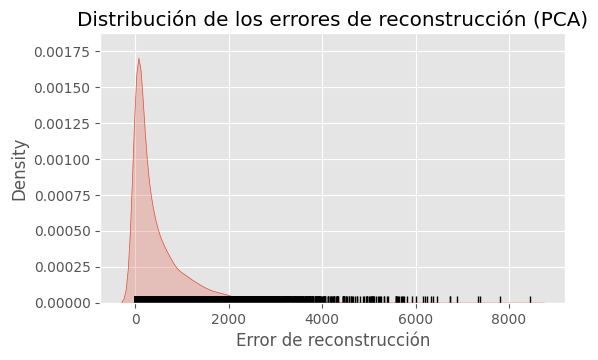

In [6]:
num_cliente =5

df = data_filtered_neg[data_filtered_neg['Cliente_ID'] == num_cliente]

# Seleccionar las columnas 'Fecha' y 'Active_energy'
df = df[[ 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]


def reconstruccion_pca(X, n_components, X_new=None):
    '''
    Función para calcular la reconstrucción y error de un conjunto de datos
    empleando un PCA

    Parameters
    ----------

    X (data.frame): datos de entrenamiento del PCA.

    X_new (data.frame): datos sobre los que aplicar la reconstrucción. Si es None,
                        se emplea X.

    id_components (list, numpy.narray): indice de las componentes empleadas para
                                        la reconstrucción, empezando por 0.
                                        Por defecto se emplean todas.

    Returns
    -------

    reconstruccion (data.frame): reconstrucción de los datos.

    error_reconstruccion (numpy.narray): error de reconstrucción de las observaciones.

    '''

    if X_new is None:
        X_new = X

    # Entrenamiento modelo PCA con escalado de los datos
    pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components))
    pca_pipeline.fit(X=X)

    # Proyectar los datos
    proyecciones = pca_pipeline.transform(X_new)

    # Reconstrucción
    reconstruccion = pca_pipeline.inverse_transform(proyecciones)
    reconstruccion = pd.DataFrame(
                        reconstruccion,
                        columns = X_new.columns,
                        index   = X_new.index
                    )

    # Error cuadrático medio de reconstrucción
    error_reconstruccion = reconstruccion - X_new
    error_reconstruccion = error_reconstruccion**2
    error_reconstruccion = error_reconstruccion.mean(axis=1)

    print(f"Reconstrucción con un PCA de {n_components} componentes")

    return reconstruccion, error_reconstruccion


# Reconstrucción con las 11 primeras componentes (90% de la varianza explicada)
# ==============================================================================
reconstruccion, error_reconstruccion = reconstruccion_pca(X=df, n_components=3)


# Distribución del error de reconstrucción
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3.5))
sns.kdeplot(
    error_reconstruccion,
    fill    = True,
    ax      = ax
)
sns.rugplot(error_reconstruccion,  ax=ax, color='black')
ax.set_title('Distribución de los errores de reconstrucción (PCA)')
ax.set_xlabel('Error de reconstrucción')

# Calcular el cuantil 0.9 del error de reconstrucción
cuantil = np.quantile(a=error_reconstruccion, q=0.9)

# Crear una nueva columna 'anomalía' y asignar 1 si es una anomalía y 0 si no lo es
df['anomalía'] = np.where(error_reconstruccion >= cuantil, 1, 0)
df

## Función generalizada para todos los clientes - hora a hora

In [7]:
def reconstruccion_pca_para_clientes_h(data_filtered_neg, n_components):
    '''
    Función para reconstruir los datos de todos los clientes utilizando PCA.

    Parameters
    ----------
    data_filtered_neg : pandas.DataFrame
        DataFrame que contiene los datos de los clientes.
    n_components : int
        Número de componentes principales a retener en PCA.

    Returns
    -------
    resultados : pandas.DataFrame
        DataFrame con los resultados de la reconstrucción y la detección de anomalías
        para todos los clientes.
    '''

    resultados = pd.DataFrame()

    # Iterar sobre cada cliente
    for num_cliente in data_filtered_neg['Cliente_ID'].unique():
        # Filtrar datos del cliente actual
        df = data_filtered_neg[data_filtered_neg['Cliente_ID'] == num_cliente]
        # df = df[['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]

        # Reconstrucción con PCA
        # reconstruccion, error_reconstruccion = reconstruccion_pca(X=df, n_components=n_components)

        df = df[['Cliente_ID', 'Fecha', 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]
        reconstruccion, error_reconstruccion = reconstruccion_pca(X=df.drop(columns=['Cliente_ID', 'Fecha']), n_components=n_components)


        # Calcular el cuantil 0.9 del error de reconstrucción
        cuantil = np.quantile(a=error_reconstruccion, q=0.90)

        # Crear una nueva columna 'anomalía' y asignar 1 si es una anomalía y 0 si no lo es
        df['anomalía'] = np.where(error_reconstruccion >= cuantil, 1, 0)

        # Agregar resultados al DataFrame principal
        resultados = pd.concat([resultados, df])

    return resultados


def reconstruccion_pca(X, n_components, X_new=None):
    '''
    Función para calcular la reconstrucción y error de un conjunto de datos
    empleando un PCA

    Parameters
    ----------

    X (data.frame): datos de entrenamiento del PCA.

    X_new (data.frame): datos sobre los que aplicar la reconstrucción. Si es None,
                        se emplea X.

    id_components (list, numpy.narray): indice de las componentes empleadas para
                                        la reconstrucción, empezando por 0.
                                        Por defecto se emplean todas.

    Returns
    -------

    reconstruccion (data.frame): reconstrucción de los datos.

    error_reconstruccion (numpy.narray): error de reconstrucción de las observaciones.

    '''

    if X_new is None:
        X_new = X

    # Entrenamiento modelo PCA con escalado de los datos
    pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components))
    pca_pipeline.fit(X=X)

    # Proyectar los datos
    proyecciones = pca_pipeline.transform(X_new)

    # Reconstrucción
    reconstruccion = pca_pipeline.inverse_transform(proyecciones)
    reconstruccion = pd.DataFrame(
                        reconstruccion,
                        columns=X_new.columns,
                        index=X_new.index
                    )

    # Error cuadrático medio de reconstrucción
    error_reconstruccion = reconstruccion - X_new
    error_reconstruccion = error_reconstruccion ** 2
    error_reconstruccion = error_reconstruccion.mean(axis=1)

    print(f"Reconstrucción con un PCA de {n_components} componentes")

    return reconstruccion, error_reconstruccion
resultados_clientes = reconstruccion_pca_para_clientes_h(data_filtered_neg, n_components=3)


Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucción con un PCA de 3 componentes
Reconstrucc

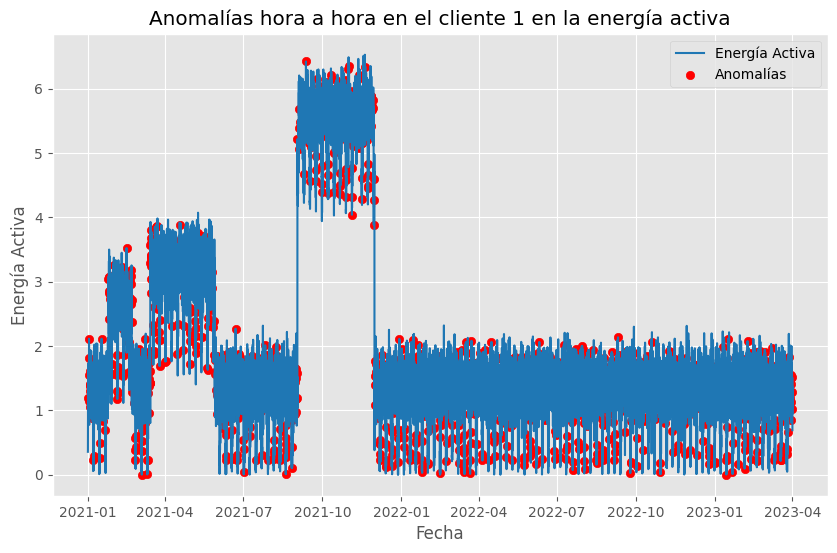

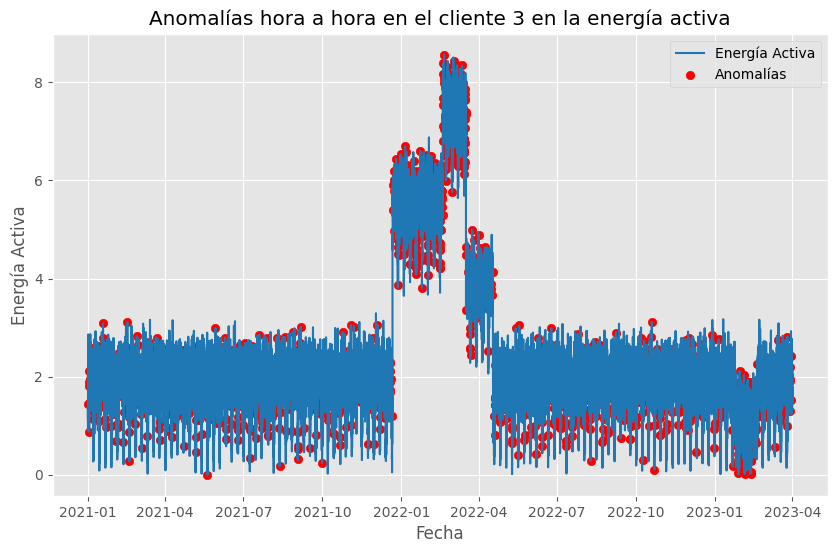

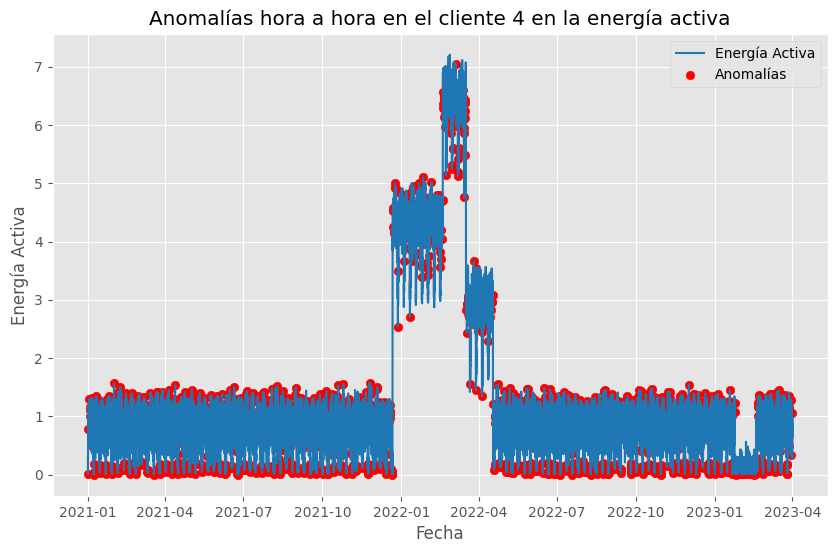

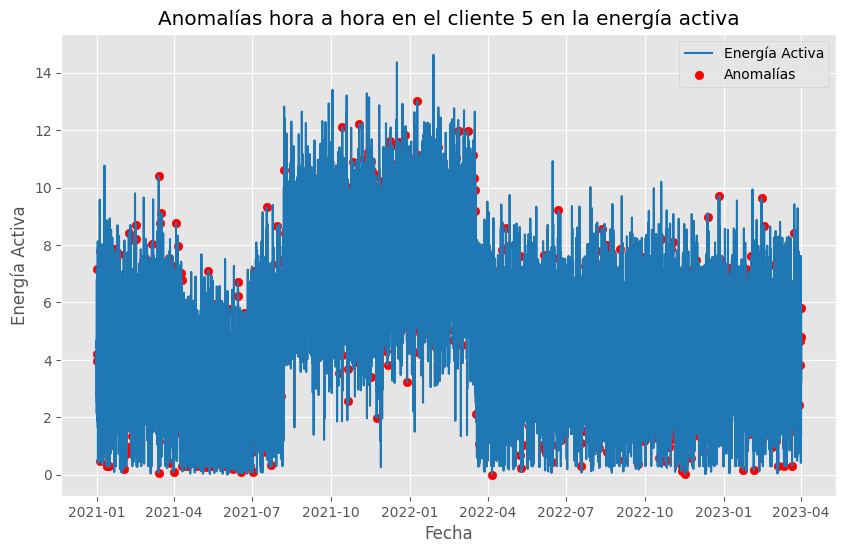

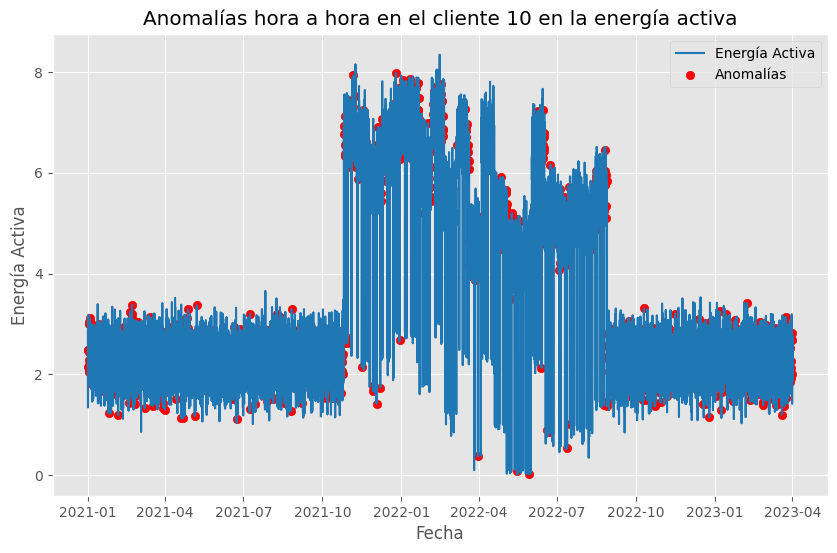

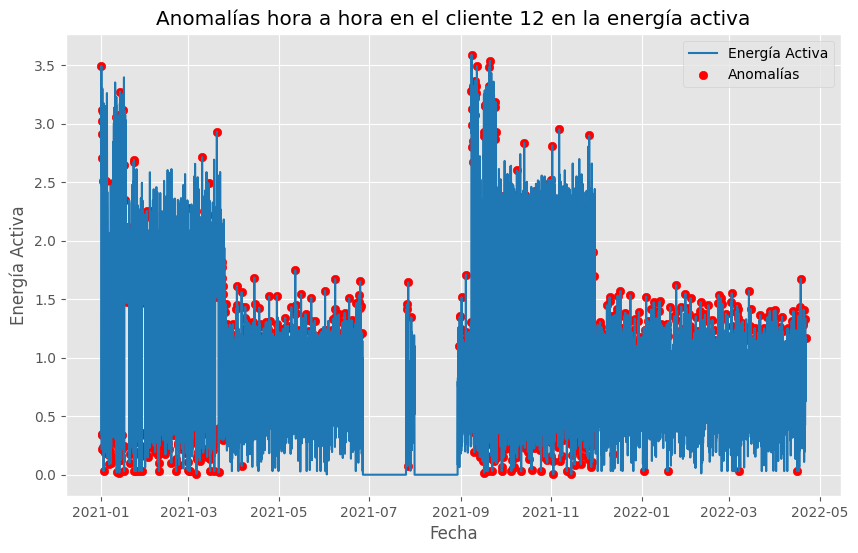

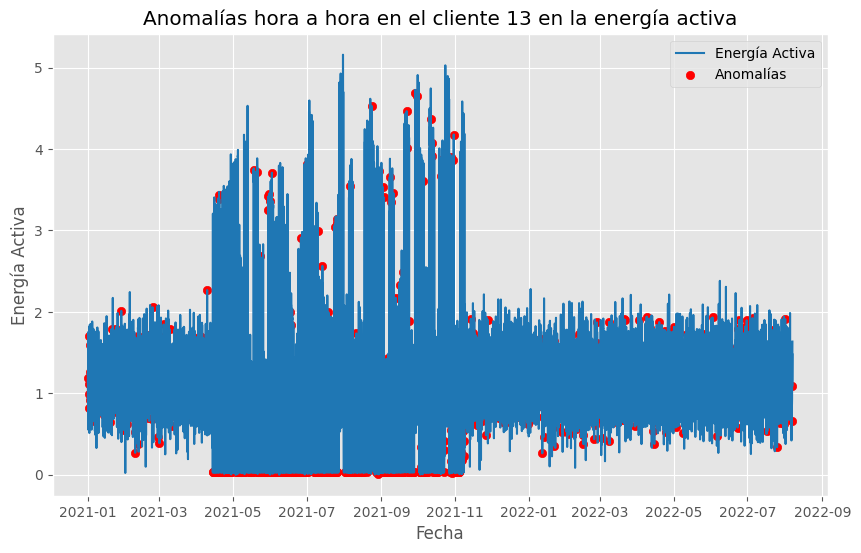

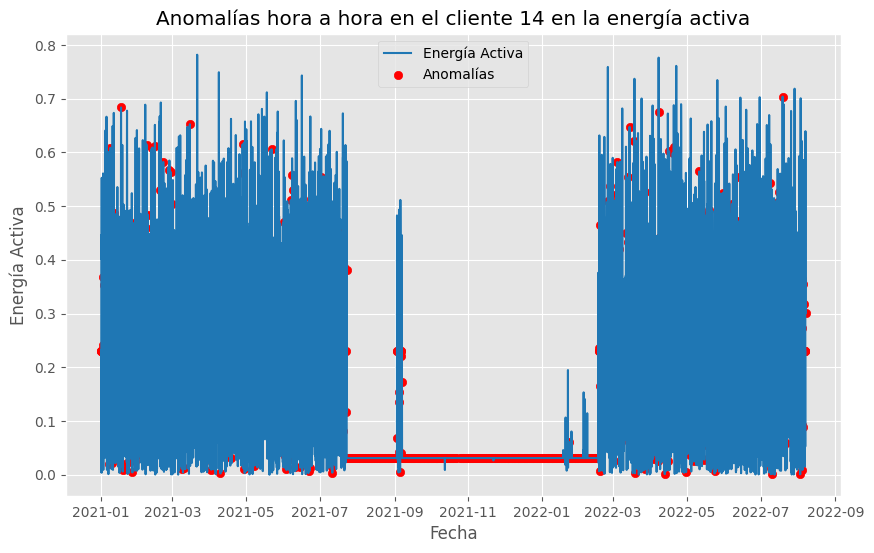

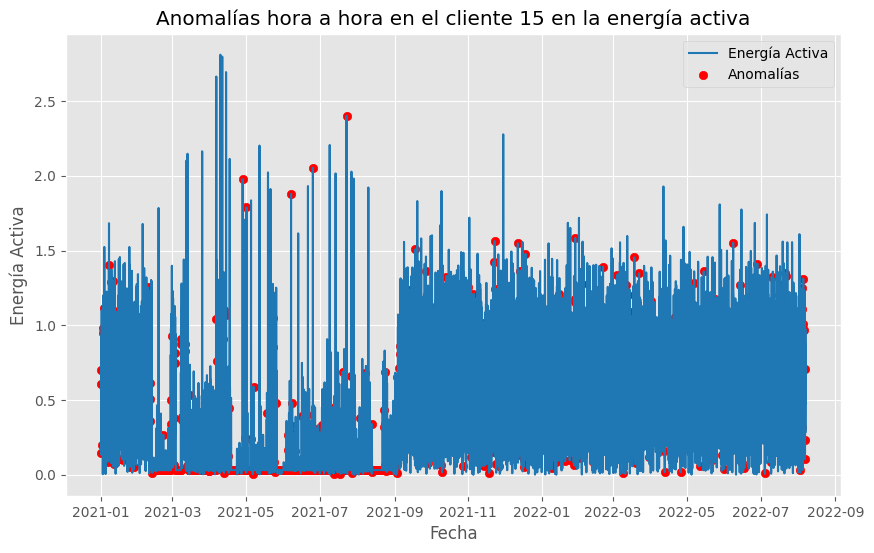

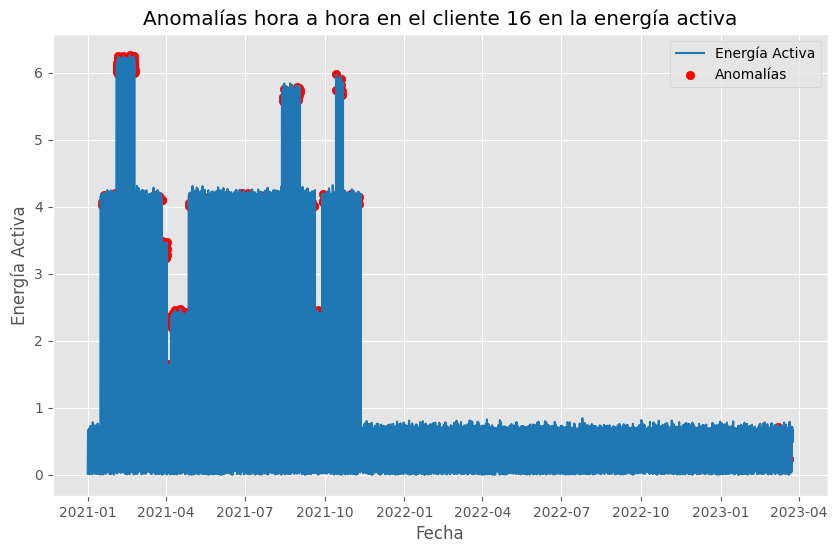

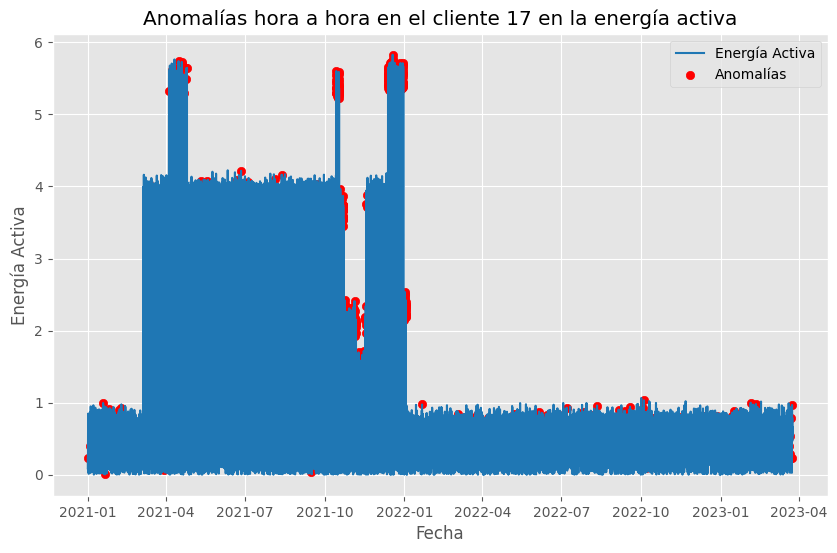

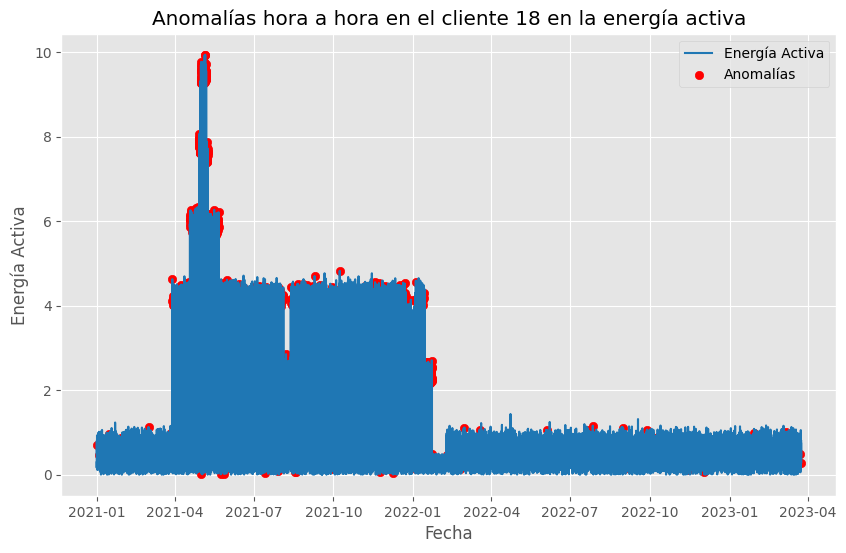

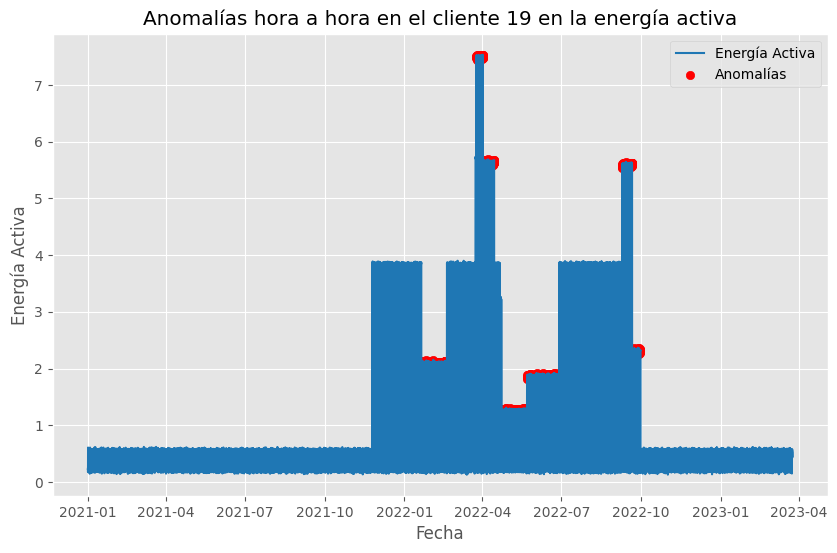

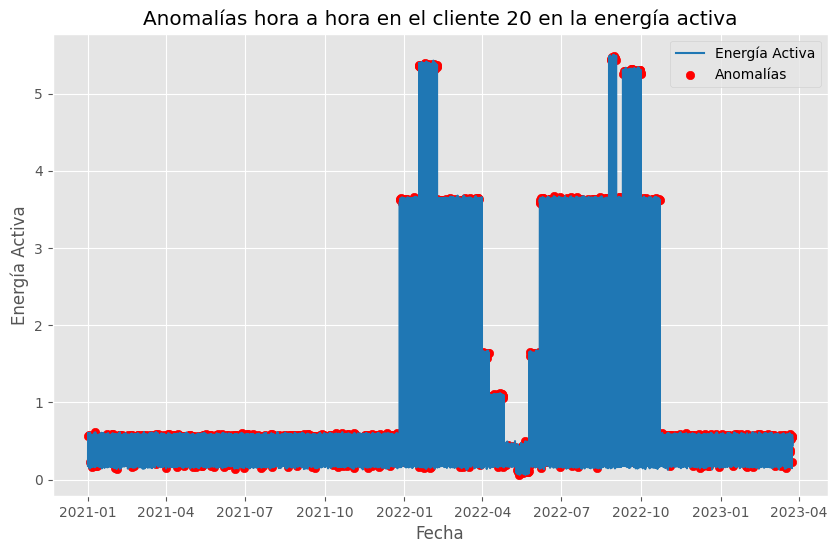

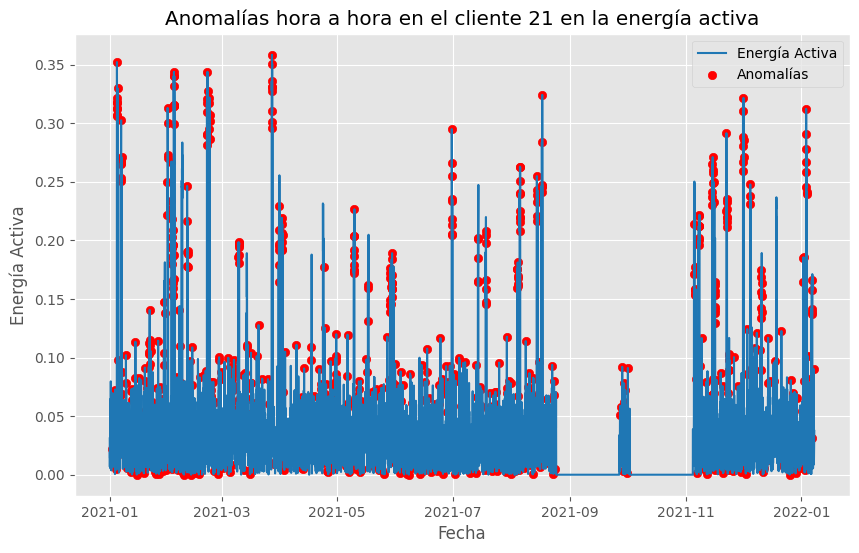

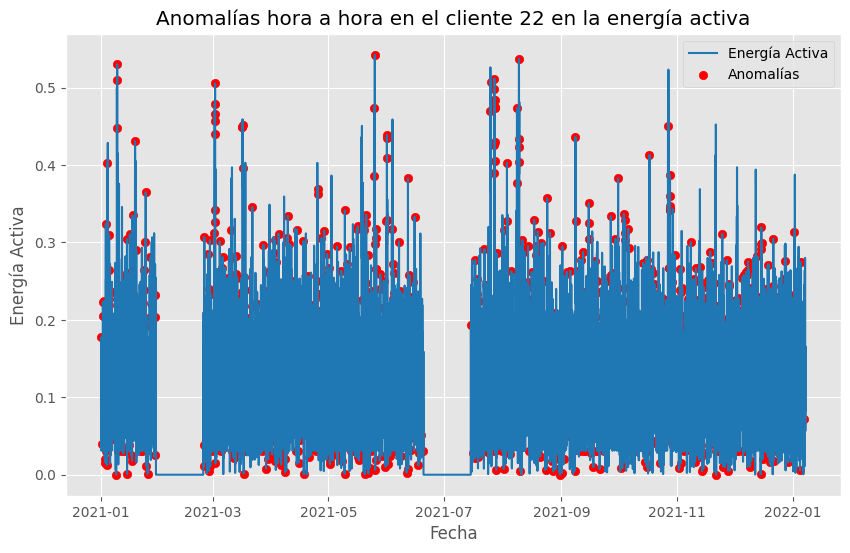

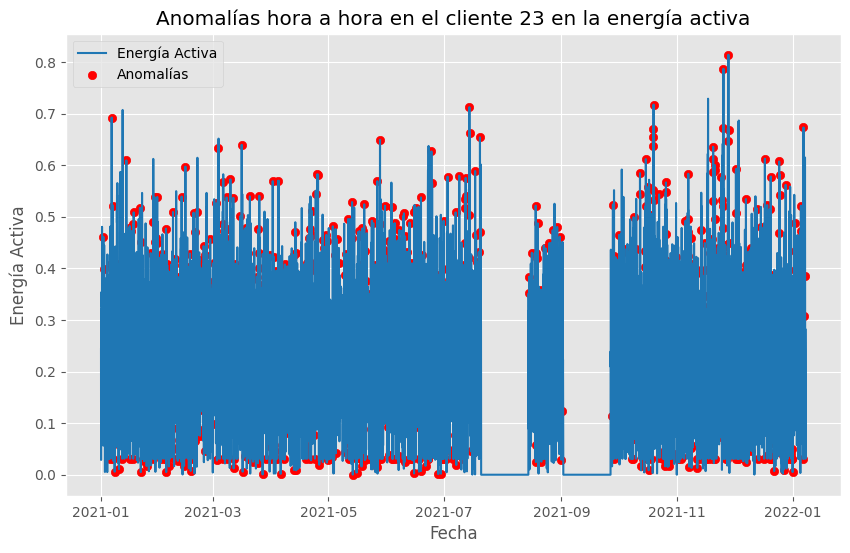

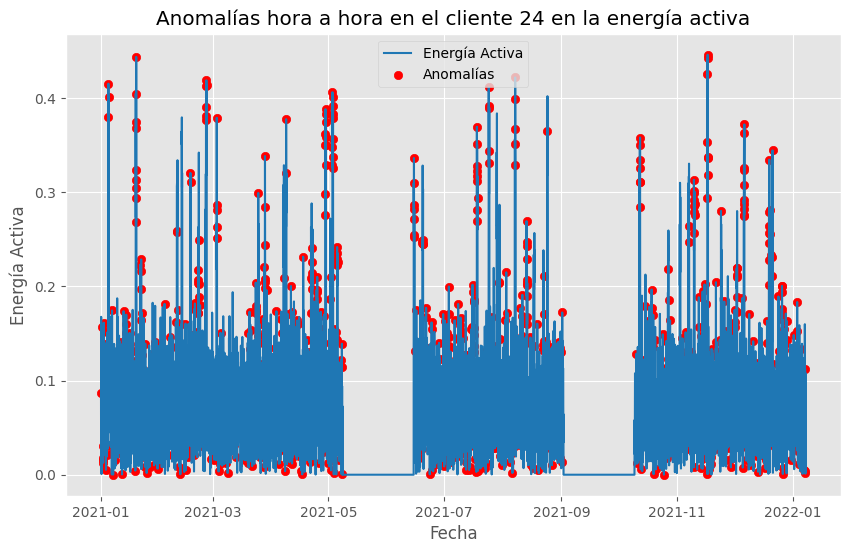

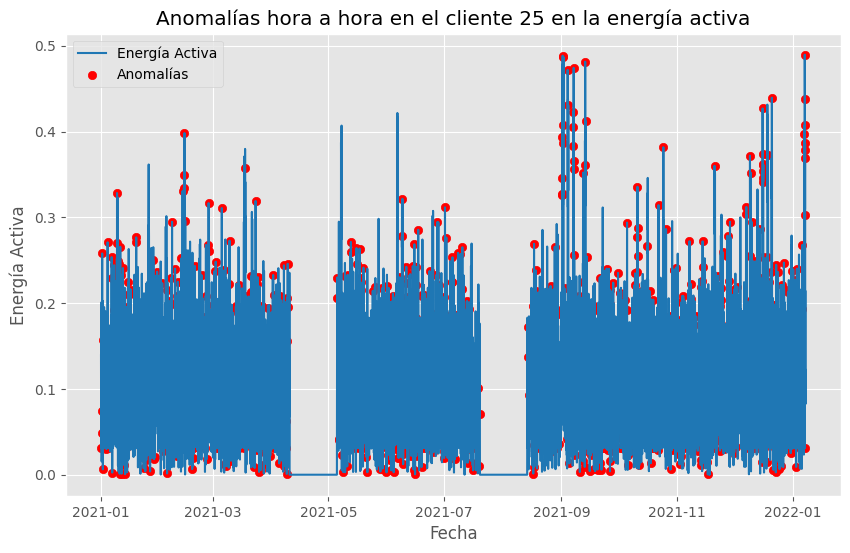

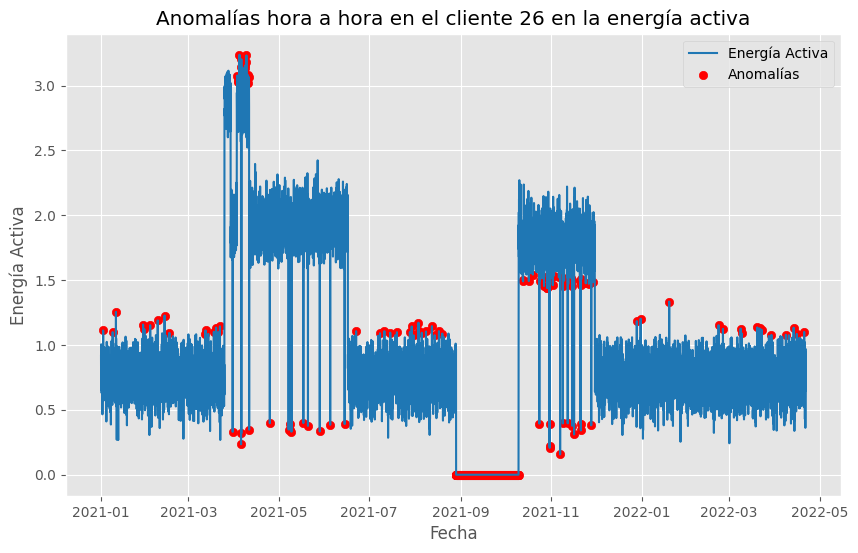

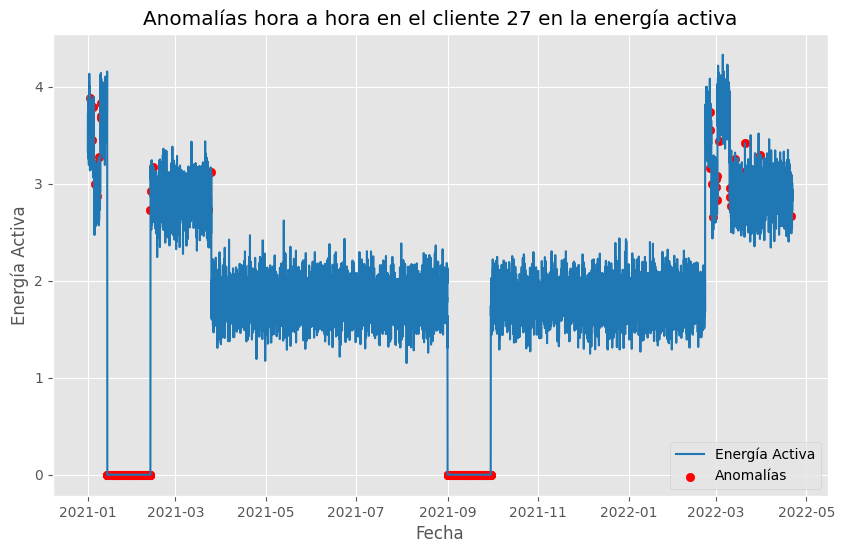

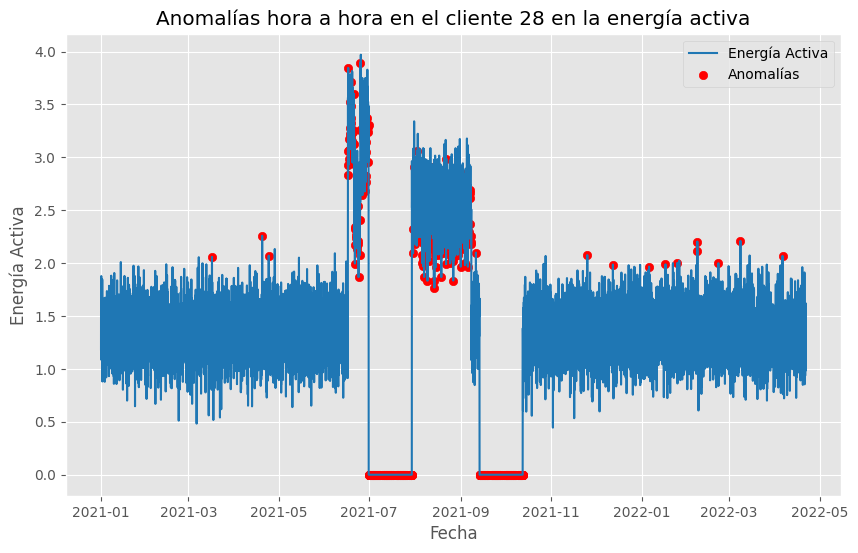

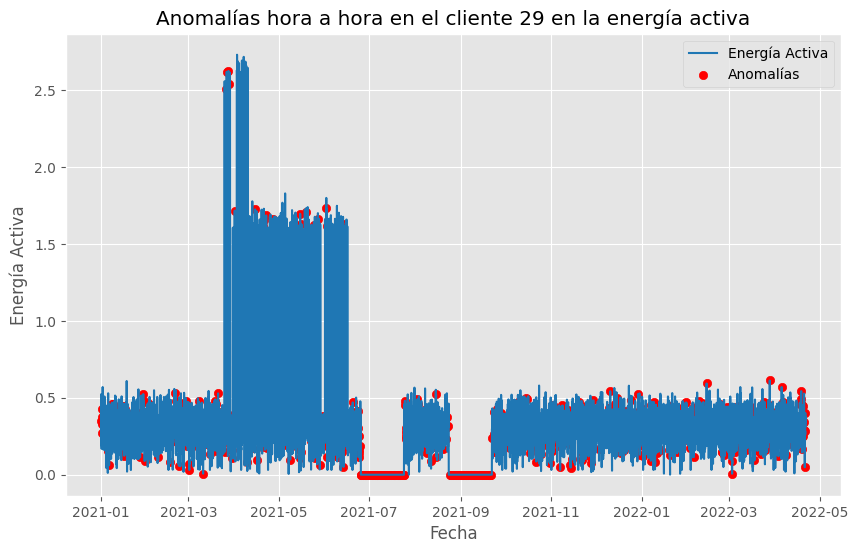

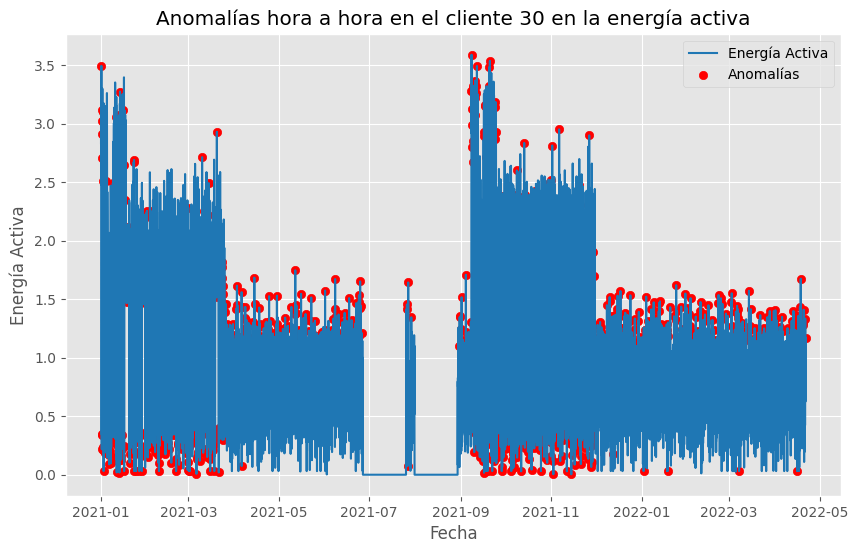

In [13]:
def graficar_energia_activa(resultados_clientes, nombre_cliente):
    # Convertir la columna 'Fecha' a tipo datetime si aún no está en ese formato
    resultados_clientes['Fecha'] = pd.to_datetime(resultados_clientes['Fecha'])

    # Graficar la fecha frente a la energía activa
    plt.figure(figsize=(10, 6))
    plt.plot(resultados_clientes['Fecha'], resultados_clientes['Active_energy'], color='tab:blue', label='Energía Activa')

    # Mostrar las anomalías como puntos azules
    anomalias = resultados_clientes[resultados_clientes['anomalía'] == 1]
    plt.scatter(anomalias['Fecha'], anomalias['Active_energy'], color='red', label='Anomalías')

    # Configuraciones adicionales del gráfico
    plt.title(f"Anomalías hora a hora en el cliente {nombre_cliente} en la energía activa")
    plt.xlabel('Fecha')
    plt.ylabel('Energía Activa')
    plt.legend()
    plt.grid(True)
    plt.show()

# Iterar sobre cada cliente en los resultados y graficar la energía activa
for cliente_id, datos_cliente in resultados_clientes.groupby('Cliente_ID'):
    nombre_cliente = f"{cliente_id}"  # Aquí puedes ajustar cómo se genera el nombre del cliente
    print("")
    #print(f'Gráfico para Cliente {cliente_id}')
    graficar_energia_activa(datos_cliente, nombre_cliente)


## Exploración de los clientes con valores promedio día

Reconstrucción con un PCA de 3 componentes


,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,anomalía
0,3.935360,3.664524,639.798936,625.861742,0
1,4.460000,3.689684,655.210424,641.844723,0
2,4.236130,3.660181,679.113935,669.247352,0
3,4.741011,3.961601,677.248752,651.665648,1
4,4.176707,3.540124,651.245912,640.629024,0
...,...,...,...,...,...
816,5.227032,2.991872,632.493420,632.056664,0
817,4.831744,3.754990,621.950350,612.033682,0
818,4.391392,3.466432,690.691108,676.862050,0
819,4.291201,3.843117,672.041828,699.756442,1


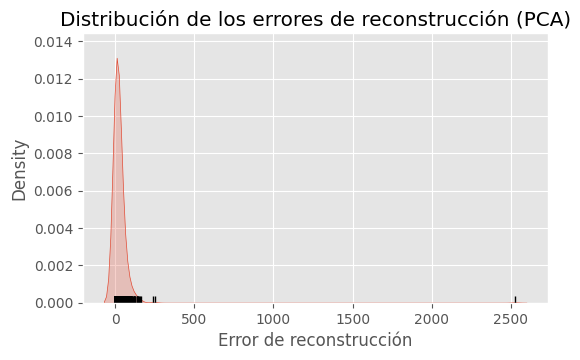

In [14]:
num_cliente =5

df = data_filtered_neg[data_filtered_neg['Cliente_ID'] == num_cliente]
df = df[['Fecha', 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]

# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])
# Establecer la columna 'Fecha' como índice del DataFrame
df.set_index('Fecha', inplace=True)
# Agrupar los datos por día y calcular la media móvil y desviación estándar móvil
df = df.resample('D').mean()
df.reset_index(inplace=True)

# Seleccionar las columnas 'Fecha' y 'Active_energy'
df = df[[ 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]


def reconstruccion_pca(X, n_components, X_new=None):
    '''
    Función para calcular la reconstrucción y error de un conjunto de datos
    empleando un PCA

    Parameters
    ----------

    X (data.frame): datos de entrenamiento del PCA.

    X_new (data.frame): datos sobre los que aplicar la reconstrucción. Si es None,
                        se emplea X.

    id_components (list, numpy.narray): indice de las componentes empleadas para
                                        la reconstrucción, empezando por 0.
                                        Por defecto se emplean todas.

    Returns
    -------

    reconstruccion (data.frame): reconstrucción de los datos.

    error_reconstruccion (numpy.narray): error de reconstrucción de las observaciones.

    '''

    if X_new is None:
        X_new = X

    # Entrenamiento modelo PCA con escalado de los datos
    pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components))
    pca_pipeline.fit(X=X)

    # Proyectar los datos
    proyecciones = pca_pipeline.transform(X_new)

    # Reconstrucción
    reconstruccion = pca_pipeline.inverse_transform(proyecciones)
    reconstruccion = pd.DataFrame(
                        reconstruccion,
                        columns = X_new.columns,
                        index   = X_new.index
                    )

    # Error cuadrático medio de reconstrucción
    error_reconstruccion = reconstruccion - X_new
    error_reconstruccion = error_reconstruccion**2
    error_reconstruccion = error_reconstruccion.mean(axis=1)

    print(f"Reconstrucción con un PCA de {n_components} componentes")

    return reconstruccion, error_reconstruccion


# Reconstrucción con las 11 primeras componentes (90% de la varianza explicada)
# ==============================================================================
reconstruccion, error_reconstruccion = reconstruccion_pca(X=df, n_components=3)


# Distribución del error de reconstrucción
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3.5))
sns.kdeplot(
    error_reconstruccion,
    fill    = True,
    ax      = ax
)
sns.rugplot(error_reconstruccion,  ax=ax, color='black')
ax.set_title('Distribución de los errores de reconstrucción (PCA)')
ax.set_xlabel('Error de reconstrucción')

# Calcular el cuantil 0.9 del error de reconstrucción
cuantil = np.quantile(a=error_reconstruccion, q=0.9)

# Crear una nueva columna 'anomalía' y asignar 1 si es una anomalía y 0 si no lo es
df['anomalía'] = np.where(error_reconstruccion >= cuantil, 1, 0)
df

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.5124982  0.39946299 0.0869623  0.00107651]

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.5124982  0.91196119 0.99892349 1.        ]

------------------
Valores originales
------------------


,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC
0,3.93536,3.664524,639.798936,625.861742
1,4.46000,3.689684,655.210424,641.844723
2,4.23613,3.660181,679.113935,669.247352



---------------------
Valores reconstruidos
---------------------


,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC
0,3.93536,3.664524,639.798936,625.861742
1,4.46000,3.689684,655.210424,641.844723
2,4.23613,3.660181,679.113935,669.247352


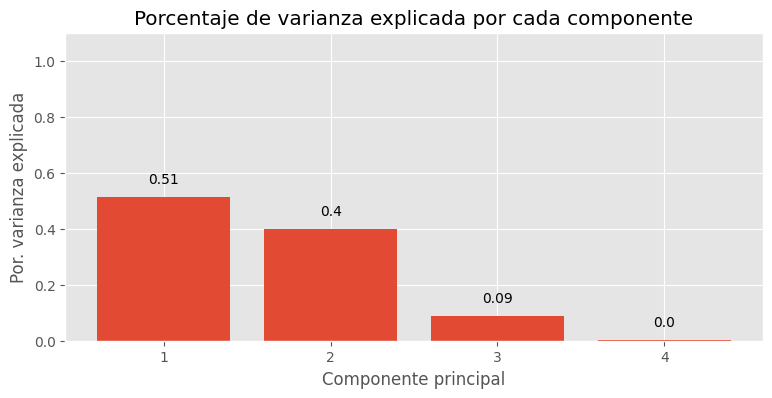

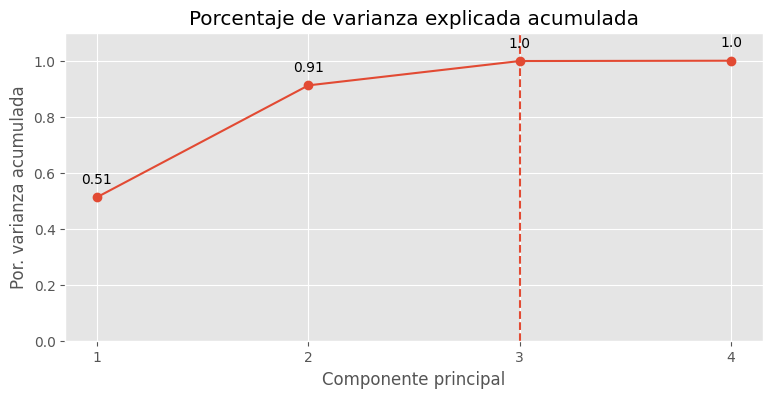

In [15]:
num_cliente =5

df = data_filtered_neg[data_filtered_neg['Cliente_ID'] == num_cliente]
df = df[['Fecha', 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]

# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])
# Establecer la columna 'Fecha' como índice del DataFrame
df.set_index('Fecha', inplace=True)
# Agrupar los datos por día y calcular la media móvil y desviación estándar móvil
df = df.resample('D').mean()
df.reset_index(inplace=True)

# Seleccionar las columnas 'Fecha' y 'Active_energy'
df = df[[ 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=None))
pca_pipeline.fit(X=df)

# Se extrae el modelo entrenado del pipeline para su diagnóstico
modelo_pca = pca_pipeline.named_steps['pca']

# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(modelo_pca.n_components_) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')
print("");


# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.plot(
    np.arange(modelo_pca.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(modelo_pca.n_components_) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.axvline(x=3, linestyle = '--')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')
print("");

# Reconstrucción de las proyecciones
# ==============================================================================
proyecciones = pca_pipeline.transform(df)
reconstruccion = pca_pipeline.inverse_transform(proyecciones)
reconstruccion = pd.DataFrame(
                    reconstruccion,
                    columns = df.columns,
                    index   = df.index
)
print('------------------')
print('Valores originales')
print('------------------')
display(reconstruccion.head(3))

print('')
print('---------------------')
print('Valores reconstruidos')
print('---------------------')
display(df.head(3))

In [11]:
def reconstruccion_pca_para_clientes_d(data_filtered_neg, n_components):
    '''
    Función para reconstruir los datos de todos los clientes utilizando PCA.

    Parameters
    ----------
    data_filtered_neg : pandas.DataFrame
        DataFrame que contiene los datos de los clientes.
    n_components : int
        Número de componentes principales a retener en PCA.

    Returns
    -------
    resultados : pandas.DataFrame
        DataFrame con los resultados de la reconstrucción y la detección de anomalías
        para todos los clientes.
    '''

    resultados = pd.DataFrame()

    # Iterar sobre cada cliente
    for num_cliente in data_filtered_neg['Cliente_ID'].unique():
        # Filtrar datos del cliente actual
        df = data_filtered_neg[data_filtered_neg['Cliente_ID'] == num_cliente]

        df = df[['Cliente_ID', 'Fecha', 'Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']]


        # Convertir la columna 'Fecha' a tipo datetime
        df['Fecha'] = pd.to_datetime(df['Fecha'])
        # Establecer la columna 'Fecha' como índice del DataFrame
        df.set_index('Fecha', inplace=True)
        # Agrupar los datos por día y calcular la media móvil y desviación estándar móvil
        df = df.resample('D').mean()
        df.reset_index(inplace=True)

        reconstruccion, error_reconstruccion = reconstruccion_pca(X=df.drop(columns=['Cliente_ID', 'Fecha']), n_components=n_components)


        # Calcular el cuantil 0.9 del error de reconstrucción
        cuantil = np.quantile(a=error_reconstruccion, q=0.9)

        # Crear una nueva columna 'anomalía' y asignar 1 si es una anomalía y 0 si no lo es
        df['anomalía'] = np.where(error_reconstruccion >= cuantil, 1, 0)

        # Agregar resultados al DataFrame principal
        resultados = pd.concat([resultados, df])

    return resultados

resultados_clientes_d = reconstruccion_pca_para_clientes_d(data_filtered_neg, n_components=2)


Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucción con un PCA de 2 componentes
Reconstrucc

In [12]:
# Iterar sobre cada cliente en los resultados y graficar la energía activa
for cliente_id, datos_cliente in resultados_clientes_d.groupby('Cliente_ID'):
    print(f'Gráfico para Cliente {cliente_id}')
    graficar_energia_activa(datos_cliente)

Gráfico para Cliente 1.0


TypeError: graficar_energia_activa() missing 1 required positional argument: 'nombre_cliente'